In [1]:
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt

import dsbhelper as dsb
import nuclei
import model as modellib


/Users/farrar/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TRAIN_DATA = 'stage1_train'

In [3]:
# configure the trainer for inference
config = nuclei.InferenceConfig()

In [4]:
# set up the dataset and load validate data
dataset_val = nuclei.NucleiDataset()
dataset_val.load_data(TRAIN_DATA, mode='validate', filter_ids=dsb.validation_set)
dataset_val.prepare()

In [5]:
# load the model
local_model_folder = 'model'
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=local_model_folder)


In [6]:
# load weights
model.load_weights('./model/mask_rcnn.h5', by_name=True)

In [7]:
# pick a specimen
#image_id = random.choice(dataset_val.image_ids)
image_id = 25
image_data = dataset_val.get_info(image_id)
print(image_data['specimen_id'])

2e172afb1f43b359f1f0208da9386aefe97c0c1afe202abfe6ec09cdca820990


In [8]:
#for image_id in dataset_val.image_ids:
#    image_data = dataset_val.get_info(image_id)
#    print('{} -> {}'.format(image_id, image_data['specimen_id']))

In [8]:
# get ground truth data
original_image, _, \
class_ids, \
rois,\
gt_masks = modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)

In [9]:
print(gt_masks.shape[-1])

41


(512, 512, 41)


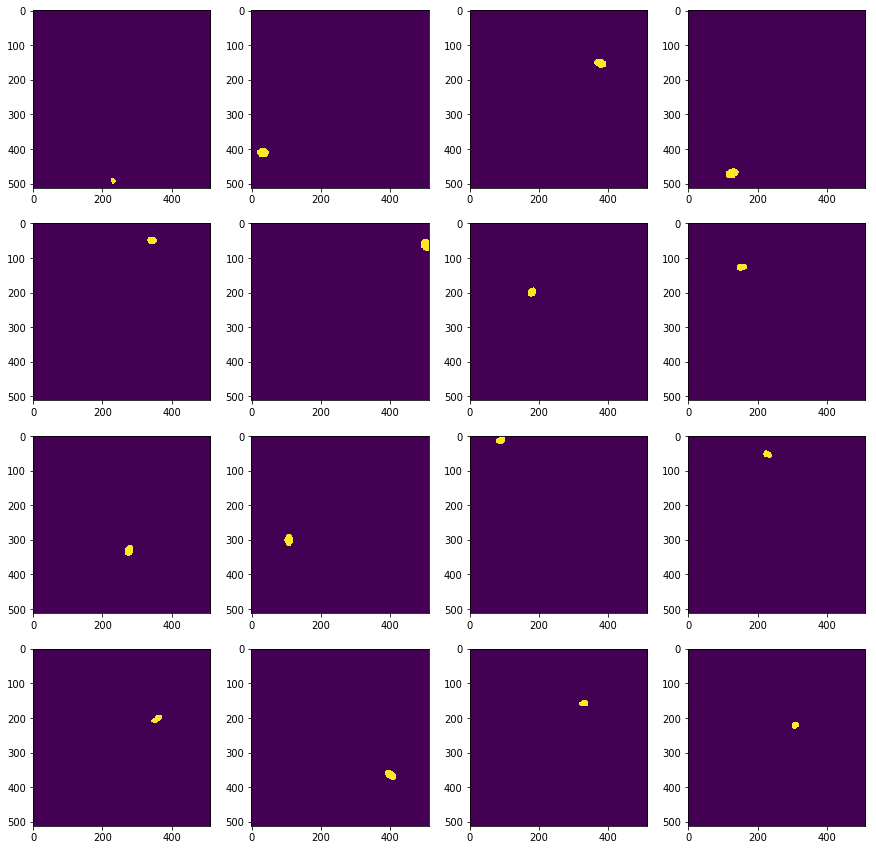

In [15]:
print(gt_masks.shape)
nrows = int(gt_masks.shape[-1]/4) + 1
if nrows > 4:
    nrows = 4
fig, axarr = plt.subplots(nrows=nrows, ncols=4, figsize=(15,15))

i = 0
for row in range(nrows):
    for col in range(4):
        if i < gt_masks.shape[-1]:
            axarr[row, col].imshow(gt_masks[:, :, i])
        i += 1

In [16]:
# run inference on the same image
p = model.detect([original_image], verbose=1)
prediction = p[0]
print(prediction['masks'].shape)
print(prediction['rois'].shape)
print(prediction['scores'].shape)
print(prediction['class_ids'].shape)

Processing 1 images
image                    shape: (512, 512, 3)         min:    3.00000  max:  255.00000
molded_images            shape: (1, 512, 512, 3)      min:  -43.82168  max:  216.78432
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000
(512, 512, 41)
(41, 4)
(41,)
(41,)


In [17]:
masks = prediction['masks']
print(masks.shape)

(512, 512, 41)


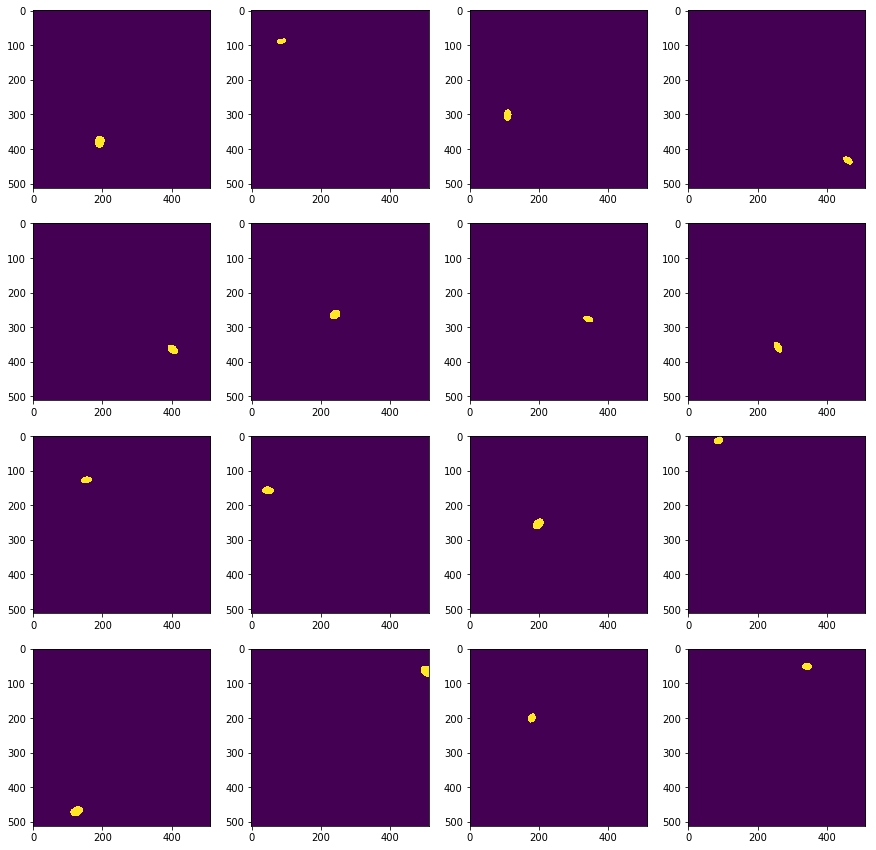

In [36]:
nrows = int(masks.shape[-1]/4) + 1
if nrows > 4:
    nrows = 4
fig, axarr = plt.subplots(nrows=nrows, ncols=4, figsize=(15,15))

i = 0
for row in range(nrows):
    for col in range(4):
        if i < masks.shape[-1]:
            axarr[row, col].imshow(masks[:, :, i])
        i += 1

In [19]:
print(gt_masks.shape)
print(masks.shape)
ap = dsb.compute_ap(gt_masks, masks)
print(ap)

(512, 512, 41)
(512, 512, 41)
0.7163134563134562


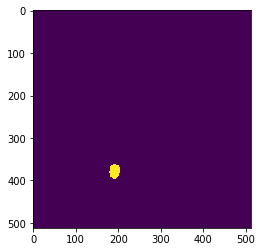

In [45]:
# ---------------------------------------------------------------------
# Creates a new mask using watershed methodology
# inspired by: Allen Goodman in this post:
# https://www.kaggle.com/c/data-science-bowl-2018/discussion/48130
# ---------------------------------------------------------------------
def watershed_mask(mask):
    
    # dilate the mask to get sure background
    kernel = np.ones((2,2), np.uint8)
    sure_bg = cv2.dilate(mask, kernel, iterations=1)
    
    # threshold with a distance transform to get the sure foreground
    dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

    # Find the unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Label with markers
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1         # Add one to all labels so that sure background is not 0, but 1
    markers[unknown==255] = 0     # Now, mark the region of unknown with zero

    # compute the watershed image
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    new_mask = cv2.watershed(mask, markers)
    new_mask[new_mask == -1] = 1
    new_mask = new_mask - 1

    if new_mask.max() == 1:
        new_mask = new_mask * 255

    return new_mask

# unit test --------------------
new_mask = watershed_mask(masks[:, :, 0]*255)
i = np.zeros((new_mask.shape[0], new_mask.shape[1],3), dtype=np.uint8)
i[:, :, 0] = new_mask
i[:, :, 1] = masks[:, :, 0]
plt.imshow(masks[:, :, 0])
plt.imshow(new_mask)

(512, 512, 41)


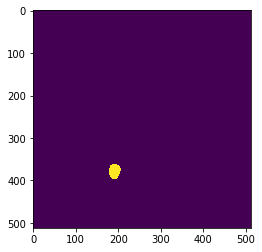

In [82]:
masks = prediction['masks']
print(masks.shape)
plt.imshow(masks[:,:,0])

1


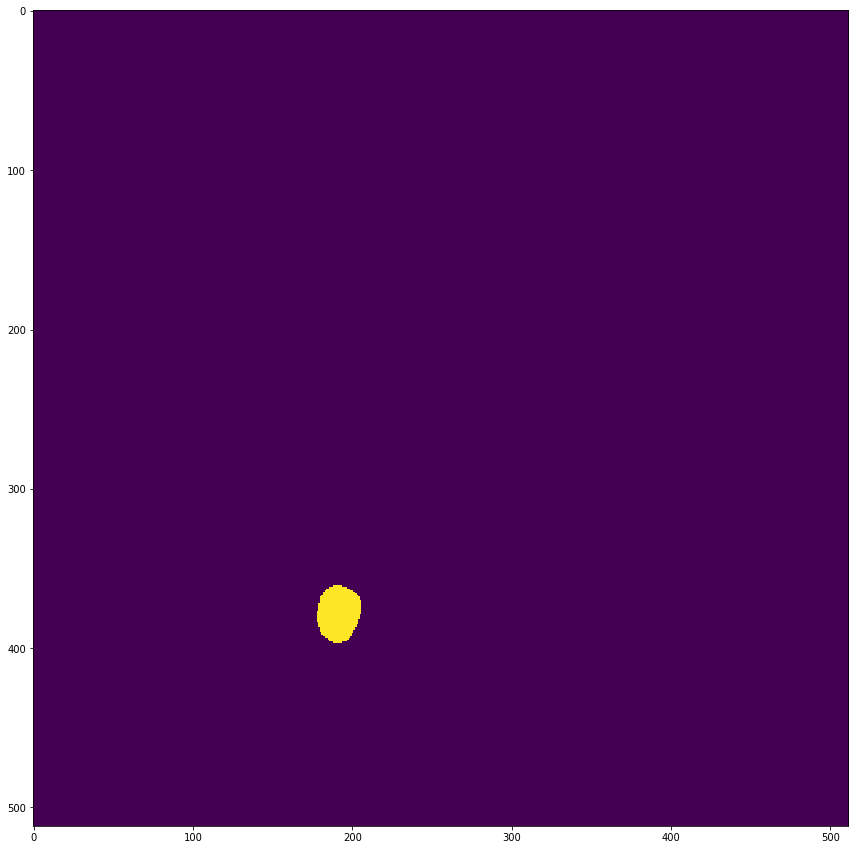

In [84]:
new_masks = np.zeros((masks.shape), dtype=np.uint8)
_, contours, _ = cv2.findContours(masks[:,:,0]*255, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print (len(contours))
#new_masks[:, :, 0] = cv2.drawContours(new_masks[:, :, 0], contours, -1, (255, 0, 0), 3)
j = cv2.drawContours(new_masks[:, :, 0]*255, contours, -1, (255, 0, 0), thickness=cv2.FILLED)
i = np.zeros((512,512,3), dtype=np.uint8)
i[:,:,0]=j
i[:,:,1]=masks[:,:,0]*255
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
plt.imshow(j)

In [85]:
new_masks = np.zeros((masks.shape), dtype=np.uint8)
for i in range(masks.shape[-1]):
    _, contours, _ = cv2.findContours(masks[:, :, i]*255, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    new_masks[:, :, i] = cv2.drawContours(new_masks[:, :, 0]*255, contours, -1, (255, 0, 0), thickness=cv2.FILLED)

print(gt_masks.shape)
print(new_masks.shape)
ap = dsb.compute_ap(gt_masks, new_masks)
print(ap)

(512, 512, 41)
(512, 512, 41)
0.6936167114185592
